# Overview

asdfljsfkdsd


## Libraries Import

In [1]:
import os
import sys
import pandas as pd

import torch
import torch.nn as nn #neural network
import torchvision as tv
import torchvision.transforms as TF
import torch.optim as optim # optimizer
import numpy as np

module_path = os.path.abspath(os.path.join(os.pardir, 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from modules import sequential_linear as sl_model #model code

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, recall_score

## Set Model

In [2]:
# set test device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
img_reduce_h=120
img_reduce_w=120

## Import Data

In [4]:
index_df = pd.read_csv("../data/image_index.csv", index_col=0)
index_df.head()

,img,data_set,condition
0,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0
1,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0
2,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0
3,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0
4,..\..\data\extracted\chest_xray\test\NORMAL\IM...,0,0


In [5]:
# update path to right directory
index_df["newpath"] = index_df.img.apply(lambda x: x[3:])

In [10]:
train_df = index_df[index_df.data_set==1]
y_true = torch.tensor(train_df["condition"].values).float()
img_paths = train_df.newpath.values

In [11]:
input_tensor = sl_model.preprocess_image_flat(img_paths, img_reduce_h, img_reduce_w)

In [12]:
input_tensor = input_tensor.to(device)

In [13]:
input_tensor.shape

torch.Size([5216, 14400])

## Train and Optimize

In [112]:
#loss functions
criterion = torch.nn.BCELoss()

In [113]:
# import model
linear_model = sl_model.linear_prototype(img_reduce_h, img_reduce_w)
linear_model.to(device) #send to CUDA!

linear_prototype3(
  (linear1): Linear(in_features=14400, out_features=320, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=320, out_features=1, bias=True)
  (termn_act): Sigmoid()
)

In [114]:
def run_optim(n_seq, learning_rate, img_paths, y_true):
    y_true = y_true.to(device)
    optimizer = optim.Adam(linear_model.parameters(), lr=learning_rate, weight_decay=0.2)
    for t in range(n_seq):

        y_pred = linear_model(img_paths).flatten()
        loss = criterion(y_pred, y_true) #calculate loss
        if t%50 == 0:
            print("training epoch", t)
            loss_copy = loss.detach().cpu()
        
        # optimzer plot
        plt.scatter(t, loss_copy)
        plt.title("Loss per Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        
        
        optimizer.zero_grad() #reset gradient)
        
        # gradient back step
        loss.backward()
    
        optimizer.step()
        
        # update parameters per learning rate (go down the gradient)
        with torch.no_grad(): #sequential
            for param in linear_model.parameters():
                param += learning_rate * param.grad

training epoch 0
training epoch 50
training epoch 100
training epoch 150
training epoch 200
training epoch 250
training epoch 300
training epoch 350
training epoch 400
training epoch 450


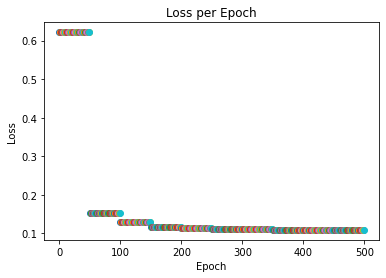

In [115]:
run_optim(500, 0.0001, input_tensor, y_true)

## Test Model

In [116]:
test_df = index_df[index_df.data_set==0]
y_true_test = torch.tensor(test_df["condition"].values).float()
img_paths_test = test_df.newpath.values

In [117]:
y_true_test = y_true_test.detach().numpy()

In [118]:
input_test_tensor = sl_model.preprocess_image_flat(img_paths_test, img_reduce_h, img_reduce_w)

In [156]:
input_test_tensor = input_test_tensor.to(device)

In [157]:
y_pred_test = linear_model(input_test_tensor) 

In [158]:
# push all tensor to CPU for metrics and convert to numpy
y_pred_test = y_pred_test.cpu()

y_pred_test = y_pred_test.flatten().detach().numpy()


In [159]:
y_pred_test = np.array([1 if ans >= 0.9 else 0 for ans in y_pred_test])

### Test Metrics

In [160]:
f1_score(y_true_test, y_pred_test)

0.8733087330873308

In [161]:
recall_score(y_true_test, y_pred_test)

0.9102564102564102

## Save Model

In [162]:
save_path = "../models/pneumonia_simple_decay_02.pt"
torch.save(linear_model.state_dict(), save_path)